In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Upload kaggle.json (API key)
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# VITON-HD dataset
!kaggle datasets download -d marquis03/high-resolution-viton-zalando-dataset
!unzip high-resolution-viton-zalando-dataset.zip -d viton_hd


Streaming output truncated to the last 5000 lines.
  inflating: viton_hd/train/openpose_json/08392_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08393_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08394_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08396_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08397_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08398_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08399_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08400_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08403_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08404_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08405_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08407_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08409_00_keypoints.json  
  inflating: viton_hd/train/openpose_json/08411_00_keypoints.json

In [ ]:
!pip install torch torchvision matplotlib
!pip install pytorch-fid
!pip install pytorch-gan-metrics
!pip install torchmetrics
!pip install torch-fidelity

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("images", exist_ok=True)





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from torchvision import transforms
from PIL import Image
import os
import torch
from torch.utils.data import Dataset

class MaskedClothingDataset(Dataset):
    def __init__(self, cloth_dir, mask_dir, image_size=64):
        self.image_files = sorted(os.listdir(cloth_dir))
        self.cloth_dir = cloth_dir
        self.mask_dir = mask_dir
        self.img_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.cloth_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])

        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        img = self.img_transform(img)
        mask = self.mask_transform(mask)

        masked_img = img * mask

        return masked_img


# Load the dataset
dataset = MaskedClothingDataset("viton_hd/train/cloth", "viton_hd/train/cloth-mask", image_size=64)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)



In [ ]:

import torchvision
import os
import numpy

real_dir = "real_clothing"
os.makedirs(real_dir, exist_ok=True)

counter = 0
for batch in train_loader:
    for img in batch:
        if counter >= 1000:
            break
        torchvision.utils.save_image(img, f"{real_dir}/{counter}.png", normalize=True)
        counter += 1
    if counter >= 1000:
        break


In [ ]:

class DCGAN_Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 1024 * 4 * 4),
            nn.BatchNorm1d(1024 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (1024, 4, 4)),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)
class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),


            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1),
            nn.Sigmoid()

        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import random

def plot_losses(g_losses, d_losses, title="Loss Curves"):
    plt.figure(figsize=(10,5))
    plt.plot(g_losses, label='Generator')
    plt.plot(d_losses, label='Discriminator')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def train_dcgan(generator, discriminator, epochs=10, z_dim=100, model_name="DCGAN"):
    criterion = nn.BCELoss()
    g_opt = optim.Adam(generator.parameters(), lr=0.0002)
    d_opt = optim.Adam(discriminator.parameters(), lr=0.0002)

    generator.to(device)
    discriminator.to(device)

    g_losses, d_losses = [], []
    folder = f"images/{model_name}"
    os.makedirs(folder, exist_ok=True)

    for epoch in range(epochs):
        for real_imgs in train_loader:
            bs = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            real_labels = torch.full((bs, 1), 0.9, device=device)  # label smoothing
            fake_labels = torch.zeros(bs, 1, device=device)


            z = torch.randn(bs, z_dim).to(device)
            fake_imgs = generator(z)
            d_loss = criterion(discriminator(real_imgs), real_labels) + \
                     criterion(discriminator(fake_imgs.detach()), fake_labels)
            d_opt.zero_grad(); d_loss.backward(); d_opt.step()

            z = torch.randn(bs, z_dim).to(device)
            fake_imgs = generator(z)
            g_loss = criterion(discriminator(fake_imgs), real_labels)
            g_opt.zero_grad(); g_loss.backward(); g_opt.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} G: {g_loss.item():.4f}")

        with torch.no_grad():
            z = torch.randn(64, z_dim).to(device)
            samples = generator(z)
            save_image(samples, f"{folder}/epoch{epoch+1}.png", normalize=True)

    plot_losses(g_losses, d_losses, title=f"{model_name} Loss")


In [ ]:
from pytorch_fid import fid_score

def calculate_fid(real_dir, fake_dir):
    fid_value = fid_score.calculate_fid_given_paths(
        [real_dir, fake_dir], batch_size=64, device=device, dims=2048
    )
    print(f"FID Score: {fake_dir}", fid_value)


In [ ]:

# WGAN Generator (same as DCGAN)
class WGAN_Generator(DCGAN_Generator):
    pass
from torch.nn.utils import spectral_norm

class WGAN_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            spectral_norm(nn.Conv2d(128, 256, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),

            #spectral_norm(nn.Conv2d(256, 512, 4, stride=2, padding=1)),
            #nn.LeakyReLU(0.2),

            nn.Flatten(),
            spectral_norm(nn.Linear(256 * 8 * 8, 1))  # No Sigmoid
        )

    def forward(self, x):
        return self.model(x)


In [ ]:

from torch.autograd import grad

def compute_gradient_penalty(D, real, fake):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolated = D(interpolated)

    if d_interpolated.ndim > 2:
      d_interpolated = d_interpolated.view(d_interpolated.size(0), -1).mean(dim=1, keepdim=True)
    fake_out = torch.ones(real.size(0), 1, device=device)
    gradients = grad(outputs=d_interpolated, inputs=interpolated,
                     grad_outputs=fake_out, create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

def train_wgan_gp(generator, discriminator, epochs=10, z_dim=100, model_name="WGAN_GP", lambda_gp=5):
    g_opt = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))
    d_opt = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))

    generator.to(device)
    discriminator.to(device)

    g_losses, d_losses = [], []
    folder = f"images/{model_name}"
    os.makedirs(folder, exist_ok=True)

    for epoch in range(epochs):
        for i, real_imgs in enumerate(train_loader):
            bs = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            for _ in range(3):  # Train discriminator more
                z = torch.randn(bs, z_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = discriminator(real_imgs)
                fake_validity = discriminator(fake_imgs)

                gp = compute_gradient_penalty(discriminator, real_imgs, fake_imgs)

                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

                d_opt.zero_grad(); d_loss.backward(); d_opt.step()

            # Generator
            z = torch.randn(bs, z_dim).to(device)
            gen_imgs = generator(z)
            g_loss = -torch.mean(discriminator(gen_imgs))

            g_opt.zero_grad(); g_loss.backward(); g_opt.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} G: {g_loss.item():.4f}")

        with torch.no_grad():
            z = torch.randn(64, z_dim).to(device)
            samples = generator(z)
            save_image(samples, f"{folder}/epoch{epoch+1}.png", normalize=True)

    plot_losses(g_losses, d_losses, title=f"{model_name} Loss")



In [ ]:
class InfoGAN_Generator(nn.Module):
    def __init__(self, z_dim=62, c_dim=2):
        super().__init__()
        self.model = nn.Sequential(
          nn.Linear(z_dim + c_dim, 1024),
          nn.ReLU(),
          nn.Linear(1024, 128 * 8 * 8),
          nn.BatchNorm1d(128 * 8 * 8),
          nn.ReLU(),
          nn.Unflatten(1, (128, 8, 8)),

          nn.ConvTranspose2d(128, 64, 4, 2, 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),

          nn.ConvTranspose2d(64, 32, 4, 2, 1),
          nn.BatchNorm2d(32),
          nn.ReLU(),

          nn.ConvTranspose2d(32, 3, 4, 2, 1),
          nn.Tanh()
      )


    def forward(self, z, c):
        x = torch.cat([z, c], dim=1)
        return self.model(x)
class InfoGAN_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )
        self.discriminator = nn.Sequential(
            nn.Linear(128 * 16 * 16, 1)
        )
        self.q_head = nn.Sequential(
            nn.Linear(128 * 16 * 16, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 2)
        )



    def forward(self, x):
        feat = self.shared(x)
        real_fake = self.discriminator(feat)
        q_pred = self.q_head(feat)
        return real_fake, q_pred

def mutual_info_loss(q_pred, c_true):
    return F.mse_loss(q_pred, c_true)


In [ ]:
class VAE_GAN_Encoder(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar
class VAE_GAN_Decoder(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class VAE_GAN_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1)
        )

    def forward(self, x):
        return self.model(x)

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


In [ ]:
def train_infogan(generator, discriminator, epochs=50, z_dim=62, c_dim=2, model_name="InfoGAN"):
    g_opt = optim.Adam(generator.parameters(), lr=0.0002)
    d_opt = optim.Adam(discriminator.parameters(), lr=0.0002)

    criterion = nn.BCEWithLogitsLoss()
    folder = f"images/{model_name}"
    os.makedirs(folder, exist_ok=True)
    g_losses, d_losses = [], []

    for epoch in range(epochs):
        for real_imgs in train_loader:
            bs = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            z = torch.randn(bs, z_dim, device=device)
            c = torch.rand(bs, c_dim, device=device)

            fake_imgs = generator(z, c)

            # Train Discriminator
            real_labels = torch.full((bs, 1), 0.9, device=device)
            fake_labels = torch.zeros(bs, 1, device=device)

            real_pred, _ = discriminator(real_imgs)
            fake_pred, _ = discriminator(fake_imgs.detach())

            d_loss = criterion(real_pred, real_labels) + criterion(fake_pred, fake_labels)
            d_opt.zero_grad(); d_loss.backward(); d_opt.step()

            for _ in range(2):# Train Generator + Q
              z = torch.randn(bs, z_dim, device=device)
              c = torch.rand(bs, c_dim, device=device)
              fake_imgs = generator(z, c)
              fake_pred, q_pred = discriminator(fake_imgs)

              g_loss = criterion(fake_pred, real_labels)
              q_loss = F.mse_loss(q_pred, c)
              total_g_loss = g_loss + 1.0 * q_loss

              g_opt.zero_grad(); total_g_loss.backward(); g_opt.step()

        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} G: {g_loss.item():.4f} Q: {q_loss.item():.4f}")
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        with torch.no_grad():
            z = torch.randn(64, z_dim).to(device)
            c = torch.rand(64, c_dim).to(device)
            samples = generator(z, c)

            save_image(samples, f"{folder}/epoch{epoch+1}.png", normalize=True)

    plot_losses(g_losses, d_losses, title=f"{model_name} Loss")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt


def train_vae_gan(encoder, decoder, discriminator, epochs=20, latent_dim=100, model_name="VAE_GAN"):
    encoder.train()
    decoder.train()
    discriminator.train()

    opt_EG = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0002, betas=(0.5, 0.999))
    opt_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    folder = f"images/{model_name}"
    os.makedirs(folder, exist_ok=True)
    g_losses, d_losses = [], []

    for epoch in range(epochs):
        for imgs in train_loader:
            imgs = imgs.to(device)
            bs = imgs.size(0)


            #  Train Discriminator
            z, mu, logvar = encoder(imgs)
            recon = decoder(z)

            real_labels = torch.full((bs, 1), 0.9, device=device)
            fake_labels = torch.zeros((bs, 1), device=device)

            d_real = discriminator(imgs)
            d_fake = discriminator(recon.detach())

            d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            #  Train Encoder + Decoder

            z, mu, logvar = encoder(imgs)
            recon = decoder(z)

            d_fake = discriminator(recon)
            adv_loss = criterion(d_fake, real_labels)
            recon_loss = F.mse_loss(recon, imgs)
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / bs

            total_loss = recon_loss + kl + adv_loss

            opt_EG.zero_grad()
            total_loss.backward()
            opt_EG.step()

        g_losses.append(total_loss.item())
        d_losses.append(d_loss.item())
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} G: {total_loss.item():.4f}")

        with torch.no_grad():
            z = torch.randn(64, latent_dim).to(device)
            samples = decoder(z)
            save_image(samples, f"{folder}/epoch{epoch+1}.png", normalize=True)

    plot_losses(g_losses, d_losses, title=f"{model_name} Loss")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaIN(nn.Module):
    def __init__(self, num_features, style_dim):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features)
        self.style_scale = nn.Linear(style_dim, num_features)
        self.style_shift = nn.Linear(style_dim, num_features)

    def forward(self, x, style):
        scale = self.style_scale(style).unsqueeze(2).unsqueeze(3)
        shift = self.style_shift(style).unsqueeze(2).unsqueeze(3)
        return self.norm(x) * scale + shift
class AdaINBlock(nn.Module):
    def __init__(self, in_ch, out_ch, style_dim):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.adain = AdaIN(out_ch, style_dim)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x, style):
        x = self.upsample(x)
        x = self.adain(x, style)
        x = self.act(x)
        return x

class StyleGAN_Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.mapping = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )

        self.const_input = nn.Parameter(torch.randn(1, 128, 4, 4))

        self.up_blocks = nn.ModuleList([
            AdaINBlock(128, 128, 128),
            AdaINBlock(128, 64, 128),
            AdaINBlock(64, 32, 128),
            AdaINBlock(32, 16, 128),
        ])


        self.to_rgb = nn.Conv2d(16, 3, 3, padding=1)


    def forward(self, z):
        style = self.mapping(z)
        x = self.const_input.expand(z.size(0), -1, -1, -1)

        for block in self.up_blocks:
           x = block(x, style)


        return torch.tanh(self.to_rgb(x))


class StyleGAN_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
def train_stylegan_lite(generator, discriminator, epochs=20, z_dim=100, model_name="StyleGAN", batch_size=64):
    criterion = nn.BCELoss()
    g_opt = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_opt = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    generator.to(device)
    discriminator.to(device)

    g_losses, d_losses = [], []
    folder = f"images/{model_name}"
    os.makedirs(folder, exist_ok=True)

    for epoch in range(epochs):
        for real_imgs in train_loader:
            bs = real_imgs.size(0)
            real_imgs = real_imgs.to(device)


            #  Train Discriminator
            real_labels = torch.full((bs, 1), 0.9, device=device)  # label smoothing
            fake_labels = torch.zeros((bs, 1), device=device)

            z = torch.randn(bs, z_dim).to(device)
            fake_imgs = generator(z)

            real_loss = criterion(discriminator(real_imgs), real_labels)
            fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
            d_loss = real_loss + fake_loss

            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            #  Train Generator
            z = torch.randn(bs, z_dim).to(device)
            fake_imgs = generator(z)
            g_loss = criterion(discriminator(fake_imgs), real_labels)

            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        print(f"[{epoch+1}/{epochs}] D: {d_loss.item():.4f} G: {g_loss.item():.4f}")

        # Save sample output
        with torch.no_grad():
            z = torch.randn(64, z_dim).to(device)
            samples = generator(z)
            save_image(samples, f"{folder}/epoch{epoch+1}.png", normalize=True)

    plot_losses(g_losses, d_losses, title=f"{model_name} Loss")


[1/30] D: 0.3286 G: 5.6649
[2/30] D: 0.3329 G: 6.3853
[3/30] D: 0.5688 G: 4.9238
[4/30] D: 0.4539 G: 2.9204
[5/30] D: 0.6142 G: 5.5977
[6/30] D: 0.4623 G: 6.0531
[7/30] D: 0.3967 G: 4.7901
[8/30] D: 0.4063 G: 3.9263
[9/30] D: 0.4207 G: 4.3366
[10/30] D: 0.7613 G: 2.8334
[11/30] D: 0.4259 G: 4.6104
[12/30] D: 0.4642 G: 3.6160
[13/30] D: 0.4043 G: 6.6680
[14/30] D: 0.5004 G: 3.8101
[15/30] D: 0.6388 G: 2.9374
[16/30] D: 0.4966 G: 3.0550
[17/30] D: 0.4090 G: 3.9302
[18/30] D: 0.5522 G: 4.4534
[19/30] D: 0.4069 G: 4.9062
[20/30] D: 0.3617 G: 4.8313
[21/30] D: 0.3740 G: 3.6720
[22/30] D: 0.4395 G: 3.1742
[23/30] D: 0.4109 G: 3.3960
[24/30] D: 0.4666 G: 4.1654
[25/30] D: 0.5363 G: 6.6992
[26/30] D: 0.3797 G: 4.4532
[27/30] D: 0.3941 G: 4.9360
[28/30] D: 0.3653 G: 4.5698
[29/30] D: 0.4619 G: 3.4001
[30/30] D: 0.4697 G: 3.3351


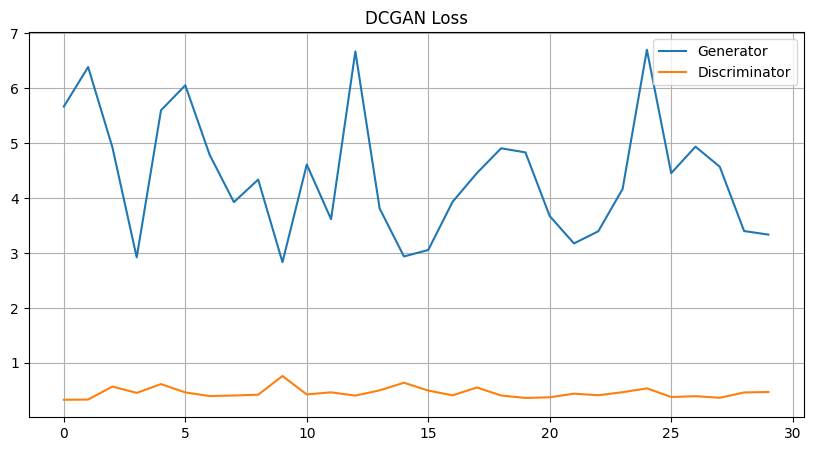

In [ ]:

# Train DCGAN

dcgan_gen = DCGAN_Generator()
dcgan_disc = DCGAN_Discriminator()
train_dcgan(dcgan_gen, dcgan_disc, epochs=30, model_name="DCGAN")



[1/30] D: -13.1808 G: 17.8112
[2/30] D: -4.0934 G: -9.4782
[3/30] D: -3.9839 G: 13.4282
[4/30] D: -4.2142 G: -7.2491
[5/30] D: -5.9042 G: -3.5889
[6/30] D: -5.0479 G: -24.5056
[7/30] D: -8.5278 G: -14.9281
[8/30] D: -3.9706 G: -21.8955
[9/30] D: -3.5744 G: -19.3344
[10/30] D: -0.8793 G: -23.0040
[11/30] D: -3.3512 G: -21.4904
[12/30] D: -3.1904 G: -32.2115
[13/30] D: -3.1092 G: -27.1230
[14/30] D: -3.8091 G: -21.9660
[15/30] D: -3.0793 G: -5.7518
[16/30] D: -2.9377 G: -20.9360
[17/30] D: -2.0166 G: -22.2856
[18/30] D: -2.1218 G: -21.4458
[19/30] D: -3.2426 G: -17.4291
[20/30] D: -3.3272 G: -21.3167
[21/30] D: -2.8751 G: -18.7674
[22/30] D: -2.8501 G: -17.5200
[23/30] D: -3.4935 G: -18.6689
[24/30] D: -2.4707 G: -23.5750
[25/30] D: 0.6093 G: -18.4817
[26/30] D: -3.7390 G: -18.7656
[27/30] D: 0.1039 G: -13.2294
[28/30] D: -4.0226 G: -18.9702
[29/30] D: -4.2117 G: -9.8112
[30/30] D: -1.9781 G: -20.5401


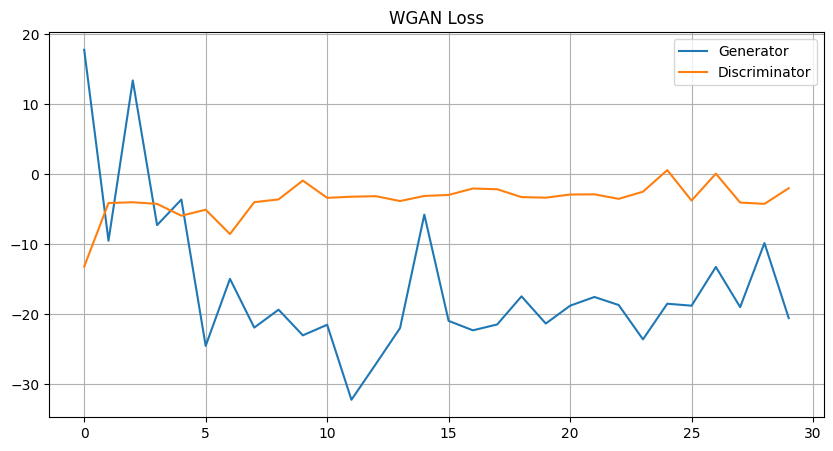

In [ ]:

# Train WGAN

wgan_gen = WGAN_Generator()
wgan_disc = WGAN_Discriminator()
train_wgan_gp(wgan_gen, wgan_disc, epochs=30, model_name="WGAN")


[1/30] D: 0.3408 G: 5.1020 Q: 0.5301
[2/30] D: 0.4029 G: 4.2565 Q: 0.4657
[3/30] D: 0.5780 G: 4.4994 Q: 0.3976
[4/30] D: 0.6489 G: 2.3734 Q: 0.5928
[5/30] D: 0.6890 G: 1.9157 Q: 0.5418
[6/30] D: 1.3634 G: 2.7149 Q: 0.4712
[7/30] D: 0.8654 G: 2.3080 Q: 0.4170
[8/30] D: 0.8221 G: 2.2352 Q: 0.4285
[9/30] D: 0.9880 G: 1.8221 Q: 0.5067
[10/30] D: 1.5786 G: 1.2275 Q: 0.4700
[11/30] D: 1.2116 G: 1.8601 Q: 0.4771
[12/30] D: 1.3110 G: 3.5123 Q: 0.5294
[13/30] D: 0.9072 G: 2.2077 Q: 0.4080
[14/30] D: 1.1664 G: 1.4531 Q: 0.5437
[15/30] D: 1.4677 G: 1.7186 Q: 0.4283
[16/30] D: 0.9219 G: 1.5077 Q: 0.5157
[17/30] D: 0.6539 G: 2.4284 Q: 0.5430
[18/30] D: 1.4768 G: 1.1416 Q: 0.5079
[19/30] D: 0.8621 G: 3.1160 Q: 0.5512
[20/30] D: 0.9478 G: 2.6156 Q: 0.5039
[21/30] D: 0.8347 G: 3.3357 Q: 0.4901
[22/30] D: 0.9250 G: 2.0871 Q: 0.5155
[23/30] D: 1.0314 G: 2.4754 Q: 0.4883
[24/30] D: 0.7169 G: 2.5877 Q: 0.5419
[25/30] D: 0.6732 G: 1.7582 Q: 0.5336
[26/30] D: 0.7269 G: 2.4379 Q: 0.4950
[27/30] D: 0.6076 G: 

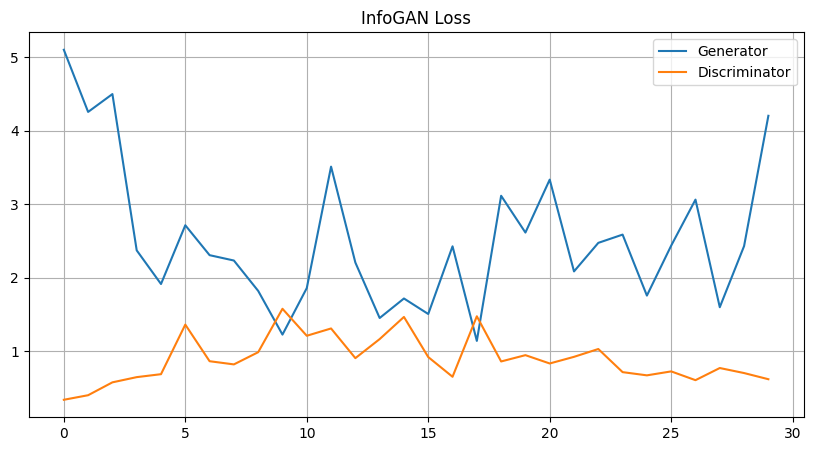

In [ ]:


# Train InfoGAN

Info_gen = InfoGAN_Generator(z_dim=62, c_dim=2).to(device)
Info_disc = InfoGAN_Discriminator().to(device)
train_infogan(Info_gen, Info_disc, epochs=30, model_name="InfoGAN")


[1/30] D: 0.3457 G: 6.9386
[2/30] D: 0.4150 G: 4.3799
[3/30] D: 0.3937 G: 7.0269
[4/30] D: 0.4621 G: 5.0978
[5/30] D: 0.3807 G: 4.9453
[6/30] D: 0.3691 G: 4.6108
[7/30] D: 0.4136 G: 4.4832
[8/30] D: 0.3562 G: 4.8499
[9/30] D: 0.3663 G: 5.6156
[10/30] D: 0.3836 G: 4.5797
[11/30] D: 0.3554 G: 6.1978
[12/30] D: 0.3680 G: 5.4997
[13/30] D: 0.4521 G: 4.2747
[14/30] D: 0.3647 G: 4.1399
[15/30] D: 0.3689 G: 5.7718
[16/30] D: 0.4729 G: 3.8203
[17/30] D: 0.6867 G: 1.9317
[18/30] D: 0.3460 G: 5.1830
[19/30] D: 0.3534 G: 5.4949
[20/30] D: 0.3648 G: 6.0425
[21/30] D: 0.3488 G: 5.1783
[22/30] D: 0.3460 G: 5.8596
[23/30] D: 0.4294 G: 4.4024
[24/30] D: 0.3448 G: 5.6630
[25/30] D: 0.3825 G: 5.0985
[26/30] D: 0.3905 G: 5.1420
[27/30] D: 0.4373 G: 4.6515
[28/30] D: 0.3653 G: 4.7674
[29/30] D: 0.3705 G: 4.9860
[30/30] D: 0.3435 G: 6.4905


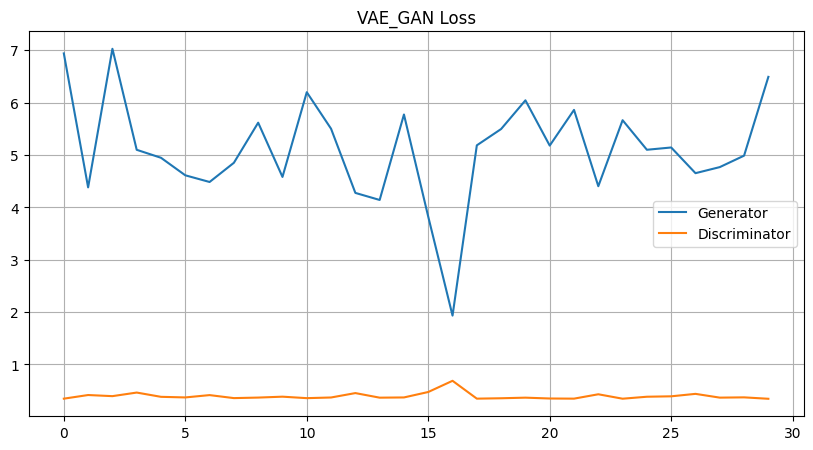

In [ ]:

# Train VAE-GAN

Encoder = VAE_GAN_Encoder(latent_dim=100).to(device)
Decoder_gen = VAE_GAN_Decoder(latent_dim=100).to(device)
disc = VAE_GAN_Discriminator().to(device)
train_vae_gan(Encoder, Decoder_gen, disc, epochs=30, latent_dim=100, model_name="VAE_GAN")

[1/30] D: 0.4591 G: 4.0329
[2/30] D: 0.8888 G: 1.0263
[3/30] D: 0.9905 G: 2.5875
[4/30] D: 0.6327 G: 2.3136
[5/30] D: 0.5572 G: 3.6858
[6/30] D: 0.6273 G: 1.7122
[7/30] D: 0.9255 G: 0.8555
[8/30] D: 0.7658 G: 3.6783
[9/30] D: 0.4220 G: 2.8900
[10/30] D: 0.6972 G: 2.7429
[11/30] D: 0.4421 G: 2.2581
[12/30] D: 0.5748 G: 2.9356
[13/30] D: 0.6791 G: 2.1799
[14/30] D: 0.5241 G: 3.6776
[15/30] D: 0.4062 G: 3.5747
[16/30] D: 0.4314 G: 3.2883
[17/30] D: 0.4308 G: 2.8764
[18/30] D: 0.4040 G: 4.1085
[19/30] D: 0.5957 G: 1.8068
[20/30] D: 0.4887 G: 3.0273
[21/30] D: 0.4840 G: 3.6216
[22/30] D: 0.4765 G: 4.5812
[23/30] D: 0.4644 G: 3.0808
[24/30] D: 0.4207 G: 4.1046
[25/30] D: 0.4515 G: 3.8106
[26/30] D: 0.4012 G: 3.3757
[27/30] D: 0.3979 G: 3.9257
[28/30] D: 0.4717 G: 3.3942
[29/30] D: 0.3995 G: 3.6157
[30/30] D: 0.5723 G: 1.6355


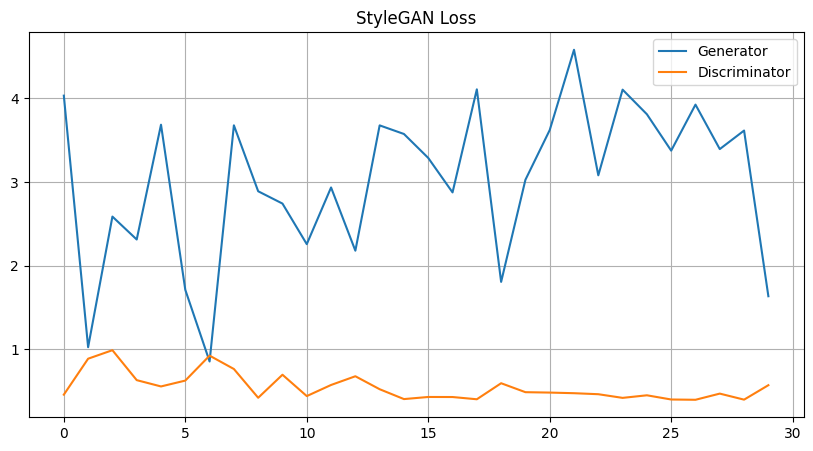

In [ ]:

# Train lite StyleGAN

style_gen = StyleGAN_Generator().to(device)
style_disc = StyleGAN_Discriminator().to(device)
train_stylegan_lite(style_gen, style_disc, epochs=30)


In [ ]:
def save_fake_samples(generator, z_dim, save_dir="generated", n_images=1000, c_dim=None):
    os.makedirs(save_dir, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for i in range(n_images):
            z = torch.randn(1, z_dim).to(device)
            if c_dim is not None:
                c = torch.rand(1, c_dim).to(device)
                img = generator(z, c)
            else:
                img = generator(z)
            img = (img + 1) / 2
            save_image(img, os.path.join(save_dir, f"{i:04d}.png"))

def report_all_fids(z_dim=100, n_images=1000):
    print("Evaluating FID for all models...")
    model_dict = {
        "dcgan": dcgan_gen,
        "wgan": wgan_gen,
        "info": Info_gen,
        "vae": Decoder_gen,
        "style": style_gen
    }

    c_dims = {
        "info": 2  #  InfoGAN needs c_dim
    }

    for name, model in model_dict.items():
        print(f"Generating images for {name}...")
        save_dir = f"generated_{name}"
        c_dim = c_dims.get(name)
        zdim = 62 if name == "info" else z_dim
        save_fake_samples(model, zdim, save_dir=save_dir, n_images=n_images, c_dim=c_dim)

        print(f"Calculating FID for {name}...")
        calculate_fid("real_clothing", save_dir)


report_all_fids()



Evaluating FID for all models...
Generating images for dcgan...
Calculating FID for dcgan...


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 236MB/s]
100%|██████████| 16/16 [00:00<00:00, 25.50it/s]


FID Score: generated_dcgan 302.6959261690736
Generating images for wgan...
Calculating FID for wgan...


100%|██████████| 16/16 [00:00<00:00, 24.56it/s]


FID Score: generated_wgan 262.95251622304636
Generating images for info...
Calculating FID for info...


100%|██████████| 16/16 [00:00<00:00, 25.29it/s]


FID Score: generated_info 330.8660912431193
Generating images for vae...
Calculating FID for vae...


100%|██████████| 16/16 [00:00<00:00, 24.80it/s]


FID Score: generated_vae 269.294765470754
Generating images for style...
Calculating FID for style...


100%|██████████| 16/16 [00:00<00:00, 24.82it/s]


FID Score: generated_style 300.15344082243837


In [ ]:
import os
import torch
from tqdm import tqdm
from torchvision import transforms
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms.functional import resize
from torchmetrics.image.kid import KernelInceptionDistance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_images_from_flat_folder(folder, size=(299, 299), max_images=1000):
    images = []
    files = sorted(os.listdir(folder))[:max_images]
    for fname in tqdm(files, desc=f"Loading from {folder}"):
        path = os.path.join(folder, fname)
        try:
            img = read_image(path)
            img = resize(img, size)
            images.append(img)
        except Exception as e:
            print(f"Skipping {fname}: {e}")
    return torch.stack(images)

from torchmetrics.image.kid import KernelInceptionDistance

def compute_kid_from_flat_folders(real_dir, fake_dir):
    real_imgs = load_images_from_flat_folder(real_dir)
    fake_imgs = load_images_from_flat_folder(fake_dir)

    metric = KernelInceptionDistance(subset_size=50, feature=2048).to(device)
    metric.update(real_imgs.to(device), real=True)
    metric.update(fake_imgs.to(device), real=False)
    kid_mean, kid_std = metric.compute()
    print(f"KID ({fake_dir}): {kid_mean.item():.4f} ± {kid_std.item():.4f}")


def report_all_kid_flat():
    print("Evaluating KID for all models from folders")
    for model in ["dcgan", "wgan", "info", "vae", "style"]:
        fake_dir = f"generated_{model}"
        if not os.path.exists(fake_dir):
            print(f"{model} folder not found.")
            continue
        compute_kid_from_flat_folders("real_clothing/real", fake_dir)

report_all_kid_flat()


Evaluating KID for all models from flat folders...


Loading from generated_dcgan: 100%|██████████| 1000/1000 [00:01<00:00, 679.07it/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


KID (generated_dcgan): 0.3311 ± 0.0178


Loading from generated_wgan: 100%|██████████| 1000/1000 [00:01<00:00, 670.18it/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


KID (generated_wgan): 0.2653 ± 0.0138


Loading from generated_info: 100%|██████████| 1000/1000 [00:01<00:00, 697.74it/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


KID (generated_info): 0.3371 ± 0.0167


Loading from generated_vae: 100%|██████████| 1000/1000 [00:01<00:00, 672.38it/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


KID (generated_vae): 0.2937 ± 0.0155


Loading from generated_style: 100%|██████████| 1000/1000 [00:01<00:00, 675.40it/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


KID (generated_style): 0.2890 ± 0.0172
